### 1. Setup Inicial do Spark

In [1]:
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from functools import reduce
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import broadcast
import warnings

# ilenciar warnings/logs
import warnings, logging
warnings.filterwarnings("ignore")

for name in ["py4j", "py4j.java_gateway", "botocore", "boto3", "urllib3"]:
    logging.getLogger(name).setLevel(logging.ERROR)
print("🔕 Warnings e logs reduzidos.")


# carregar variáveis do .env
load_dotenv()

# Parar qualquer sessão Spark existente
try:
    if 'spark' in locals():
        spark.stop()
        print("Spark session anterior fechada")
    else:
        print("Nenhuma sessão anterior encontrada")
except Exception as e:
    print(f"Erro ao fechar sessão Spark: {e}")

spark = (
    SparkSession.builder
      .appName("IBGE_Silver")
      .config("spark.driver.memory", "4g")
      .config("spark.executor.memory", "4g")
      .config("spark.driver.bindAddress", "127.0.0.1")
      .config("spark.driver.host", "localhost")
      .config("spark.jars.packages", "org.postgresql:postgresql:42.7.3")
      .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

print("✅ Spark session criada.")

🔕 Warnings e logs reduzidos.
Nenhuma sessão anterior encontrada


:: loading settings :: url = jar:file:/opt/homebrew/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/hgirardi/.ivy2.5.2/cache
The jars for the packages stored in: /Users/hgirardi/.ivy2.5.2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7aba7b6e-f023-4b2a-9bd7-eda56f2012ef;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.3 in central
	found org.checkerframework#checker-qual;3.42.0 in central
:: resolution report :: resolve 57ms :: artifacts dl 2ms
	:: modules in use:
	org.checkerframework#checker-qual;3.42.0 from central in [default]
	org.postgresql#postgresql;42.7.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	------------------

✅ Spark session criada.


### 2. Setup Inicial do Postgres + Criação do schema Silver

In [ ]:
import psycopg2

# Dados de conexão com o Postgres
jdbc_url = f"jdbc:postgresql://{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/{os.getenv('POSTGRES_DATABASE')}?reWriteBatchedInserts=true"
connection_properties = {
    "user": os.getenv('POSTGRES_USER'),
    "password": os.getenv('POSTGRES_PASSWORD'),
    "driver": "org.postgresql.Driver",
    "batchsize": "5000"
}

""" Criação do schema Silver no banco de dados """

print(f"== Iniciando processo de criação do schema ==")
create_schema_sql = "CREATE SCHEMA IF NOT EXISTS silver;"

try:

    conn = psycopg2.connect(
        host=os.getenv('POSTGRES_HOST'),
        port=os.getenv('POSTGRES_PORT'),
        database=os.getenv('POSTGRES_DATABASE'),
        user=connection_properties['user'],
        password=connection_properties['password']
    )
    print(f"✅ Connexão estabelecida!")

    with conn.cursor() as cursor:
        cursor.execute(create_schema_sql)
        conn.commit()
        print("✅ SQL executado!")
    

except psycopg2.Error as e:
    print(f"❌ Erro ao executar SQL: {e}")
    raise
except Exception as e:
    print(f"❌ Erro genérico: {e}")
    raise


print(f"== Processo finalizado ==")


== Iniciando processo de criação do schema ==
✅ Connexão estabelecida!
✅ SQL executado!
== Processo finalizado ==


### 3. Buscar tabelas raw do schema Bronze + Manipulação inicial

In [3]:
def get_bronze_tables(conn):
    """Busca todas as tabelas do schema bronze e retorna em array"""
    try:
                
        with conn.cursor() as cursor:
            cursor.execute("""
                SELECT table_name 
                FROM information_schema.tables 
                WHERE table_schema = 'bronze'
            """)
            
            tabelas = [row[0] for row in cursor.fetchall()]
            print(f"✅ Tabelas encontradas no schema bronze: {tabelas}")
            return tabelas
            
    except Exception as e:
        print(f"❌ Erro ao buscar tabelas: {e}")
        return []

# Buscar todas as tabelas
bronze_tables = get_bronze_tables(conn)
conn.close()

✅ Tabelas encontradas no schema bronze: ['raw_dicionario_pnad_covid_112020_20220621', 'raw_pnad_covid_112020', 'raw_pnad_covid_092020', 'raw_pnad_covid_102020']


In [4]:
# Remover tabela de dicionário da lista
tabelas = [table for table in bronze_tables if 'dicionario' not in table.lower()]
dicionario = [table for table in bronze_tables if 'dicionario' in table.lower()]

print(f"Tabelas de dados: {tabelas}")
print(f"Tabelas de dicionário: {dicionario}")

Tabelas de dados: ['raw_pnad_covid_112020', 'raw_pnad_covid_092020', 'raw_pnad_covid_102020']
Tabelas de dicionário: ['raw_dicionario_pnad_covid_112020_20220621']


In [5]:
""" Aprender se as tabelas tem a mesma estrutura (número de colunas) """

dataframes = []
for tabela in tabelas:
    df = spark.read.jdbc(jdbc_url, f"bronze.{tabela}", properties=connection_properties)
    dataframes.append(df)

    # print(f"Tabela: {tabela}") 
    # print(f"Colunas: {len(df.columns)}")
    # print(f"Linhas: {df.count()}")
    # df.show(10)
    # df.printSchema()
    # print(f"-----")
    # print(f"")

df_final = reduce(lambda a, b: a.unionByName(b, allowMissingColumns=True), dataframes)
df_final = df_final.persist(StorageLevel.MEMORY_AND_DISK)
print("Registros Bronze (uma ação):", df_final.count())


Registros Bronze (uma ação): 1149197


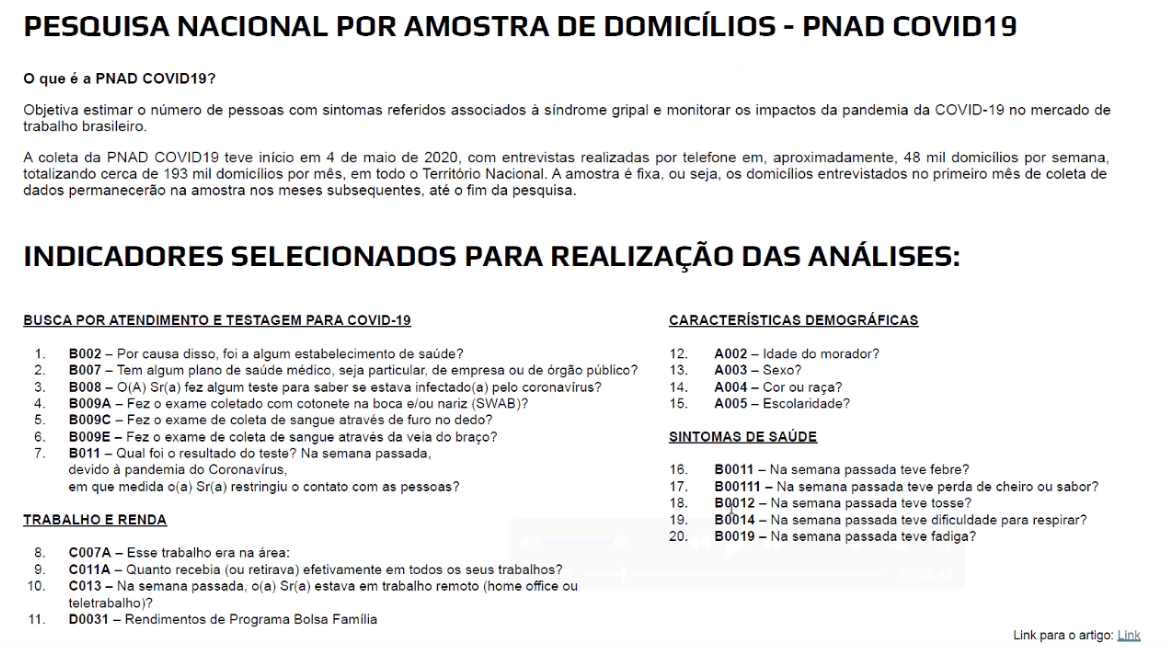

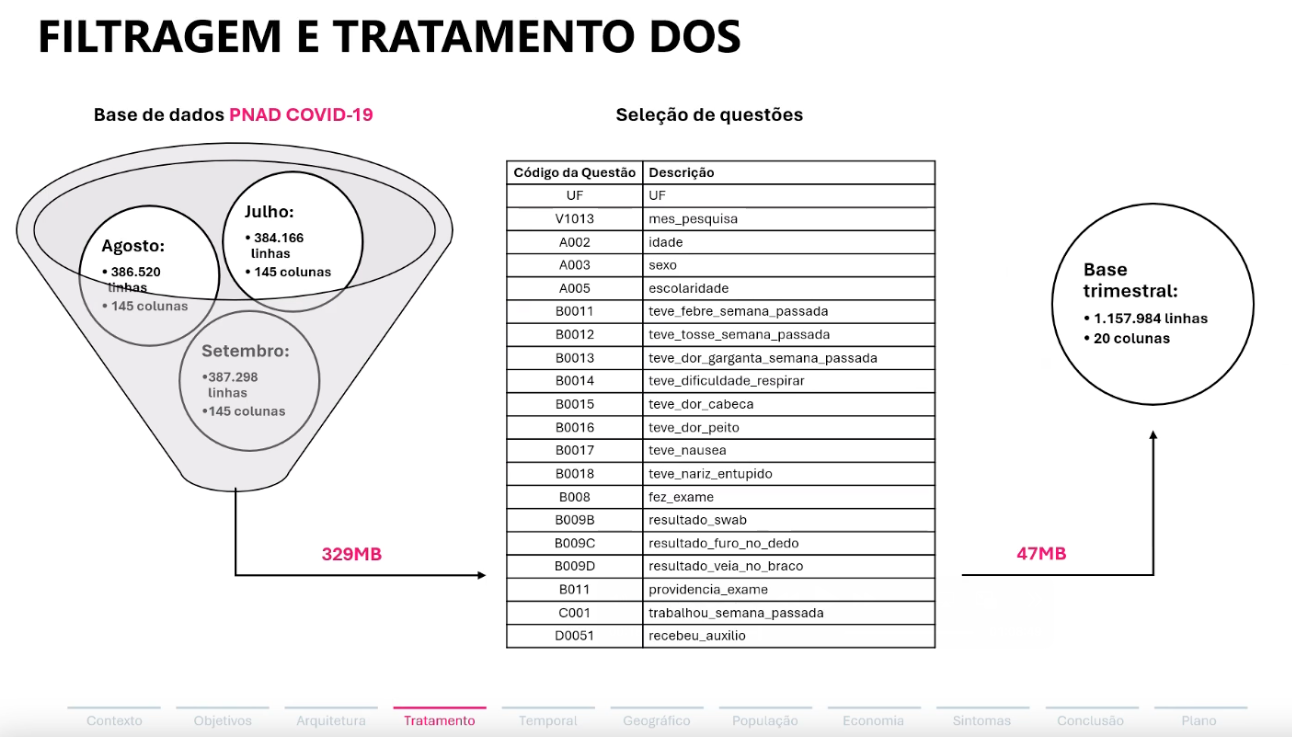

In [6]:
# checar como os valores das três colunas adicionais de novembro (A006A, A006B e A007A) ficaram no df_final
# Confirmado que todos valores estão NULL
df_final \
    .select(
            F.col("Ano"),
            F.col("UF"),
            F.col("CAPITAL"),
            F.col("V1013"),
            F.col("A006A"),
            F.col("A006B"),
            F.col("A007A")
        ) \
    .filter(
        (F.col("V1013")=="10") &
        (F.col("A006A").isNotNull()) &
        (F.col("A006B").isNotNull()) &
        (F.col("A007A").isNotNull())
    ) \
    .show()

+---+---+-------+-----+-----+-----+-----+
|Ano| UF|CAPITAL|V1013|A006A|A006B|A007A|
+---+---+-------+-----+-----+-----+-----+
+---+---+-------+-----+-----+-----+-----+



### 4. Ajustar dicionário

In [7]:
# Carregamento do dicionário
print(f"tabela: bronze.{dicionario[0]}")
df_dicionario = spark.read.jdbc(jdbc_url, f"bronze.{dicionario[0]}", properties=connection_properties)
df_dicionario.persist(StorageLevel.MEMORY_AND_DISK)

df_dicionario.show(10)
df_dicionario.printSchema()

tabela: bronze.raw_dicionario_pnad_covid_112020_20220621


+-----+--------------------------------------+--------------------+----------+--------------------+----------+--------------------+
|index|Dicionário das variáveis da PNAD COVID|          Unnamed: 1|Unnamed: 2|          Unnamed: 3|Unnamed: 4|          Unnamed: 5|
+-----+--------------------------------------+--------------------+----------+--------------------+----------+--------------------+
|  110|                                   nan|                 nan|       nan|                 nan|        14|       Outro parente|
|  220|                                   nan|                 nan|       nan|                 nan|         3|            Não sabe|
|  165|                                   nan|                 nan|       nan|                 nan|         5|              5 dias|
|  605|                                   nan|                 nan|       nan|                 nan|         3|       Não solicitou|
|  495|                                   nan|                 nan|       na

In [8]:
# Analizar as perguntas no dicionário

df_dicionario.createOrReplaceTempView("bronze_dicionario")

query = """
select `Unnamed: 1` as codigo
     , `Unnamed: 2` as grupo
     , `Unnamed: 3` as pergunta
     , `index`
from bronze_dicionario
where `Unnamed: 3` != 'nan'
  and CAST(`index` as INTEGER) >= 96
order by CAST(`index` as INTEGER)
"""

perguntas_df = spark.sql(query)


In [9]:
perguntas_df.show(1000, truncate=False)

+-------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|codigo |grupo|pergunta                                                                                                                                                                      |index|
+-------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|A001   |A1   |Número de ordem                                                                                                                                                               |96   |
|A001A  |A1a  |Condição no domicílio                                                                                                                                                         |97   |
|A001B1 |A1b  |

#### 4.1 Selecionar perguntas

**Demografia:**
- UF
- V1022 - Situação do domicílio

**Dados temporais:**
- V1012 - Semana no mês
- V1013 - Mês da pesquisa

**Perguntas:**
- A002 - Idade do morador 
- A003 - Sexo
- A004 - Cor ou raça
- A005 - Escolaridade

- B008		O(A) Sr(a) fez algum teste para saber se estava infectado(a) pelo coronavírus? 
- B009A		Fez o exame coletado com cotonete na boca e/ou nariz (SWAB)? 
- B009B		Qual o resultado?
- B009C		Fez o exame de coleta de sangue através de furo no dedo?
- B009D		Qual o resultado?
- B009E		Fez o exame de coleta de sangue através da veia da braço?
- B009F		Qual o resultado?
- B011		Qual foi o resultado do teste?  Na semana passada, devido à pandemia do Coronavírus, em que medida o(a) Sr(a) restringiu o contato com as pessoas? 
        
- B0011		Na semana passada teve febre?  
- B0012		Na semana passada teve tosse?
- B0013		Na semana passada teve dor de garganta?
- B0014		Na semana passada teve dificuldade para respirar?
- B0015		Na semana passada teve dor de cabeça?
- B0016		Na semana passada teve dor no peito?
- B0017		Na semana passada teve náusea?
- B0018		Na semana passada teve nariz entupido ou escorrendo?
- B0019		Na semana passada teve fadiga?
- B00110		Na semana passada teve dor nos olhos?
- B00111		Na semana passada teve perda de cheiro ou sabor?
- B00112		Na semana passada teve dor muscular?
- B00113		Na semana passada teve diarreia?

- C013		Na semana passada, o(a) Sr(a) estava em trabalho remoto (home office ou teletrabalho)?
        

**Sócio/Econômico**
- C01011 - Número da faixa do rendimento/retirada em dinheiro
- D0051 - Auxílios emergenciais relacionados ao coronavirus        

In [28]:
# perguntas selecionadas + tradução
colunas_selecionadas = [
    
    # Demografia
    ("UF", "estado"),
    ("V1012", "semana_mes"),

    # Temporal
    ("V1013", "mes_pesquisa"),
    ("V1022", "situacao_domicilio"), 

    # Características pessoais
    ("A002", "idade"),
    ("A003", "sexo"),
    ("A004", "cor_raca"),
    ("A005", "escolaridade"),

    # Testes COVID
    ("B008", "fez_teste_covid"),
    ("B009A", "teste_swab"),
    ("B009B", "resultado_swab"),
    ("B009C", "teste_sangue_dedo"),
    ("B009D", "resultado_sangue_dedo"),
    ("B009E", "teste_sangue_braco"),
    ("B009F", "resultado_sangue_braco"),
    ("B011", "restricao_contato"),

    # Sintomas
    ("B0011", "febre"),
    ("B0012", "tosse"),
    ("B0013", "dor_garganta"),
    ("B0014", "dificuldade_respirar"),
    ("B0015", "dor_cabeca"),
    ("B0016", "dor_peito"),
    ("B0017", "nausea"),
    ("B0018", "nariz_entupido"),
    ("B0019", "fadiga"),
    ("B00110", "dor_olhos"),
    ("B00111", "perda_olfato_paladar"),
    ("B00112", "dor_muscular"),
    ("B00113", "diarreia"),

    # Trabalho
    ("C013", "trabalho_remoto"),

    # Socioeconômico
    ("C01011", "faixa_rendimento"),
    ("D0051", "auxilio_emergencial")
]

In [26]:
def analyze_unique_values(df, colunas_selecionadas):
    """
    Mostra valores únicos e contagens para cada coluna
    """
    
    df_temp = df.select(*[F.col(src).alias(dst) for src, dst in colunas_selecionadas])

    for nome_col, novo_nome in colunas_selecionadas:
        print(f"\n=== COLUNA: {novo_nome.upper()} ===")
        
        # Valores únicos com contagem
        unique_values = df_temp.groupBy(novo_nome).count().orderBy("count", ascending=False)
        total_unique = unique_values.count()
        
        print(f"Total de valores únicos: {total_unique}")
        
        # Mostrar os valores mais frequentes
        unique_values.show(1000, truncate=False)
        
        print("-" * 50)

In [ ]:
# analizar o conteúdo de cada coluna para entender possíveis valores e ajustar a tipagem delas
analyze_unique_values(df_final, colunas_selecionadas)


=== COLUNA: ESTADO ===
Total de valores únicos: 27
+------+------+
|estado|count |
+------+------+
|31    |103096|
|35    |98021 |
|33    |87405 |
|42    |70990 |
|43    |66446 |
|21    |61200 |
|41    |59984 |
|29    |51310 |
|26    |50811 |
|23    |50536 |
|32    |47511 |
|52    |41977 |
|15    |35764 |
|27    |34450 |
|51    |34156 |
|13    |31355 |
|25    |29687 |
|50    |26434 |
|22    |25137 |
|28    |24216 |
|24    |23552 |
|53    |19906 |
|12    |18834 |
|14    |16674 |
|11    |16622 |
|17    |15446 |
|16    |7677  |
+------+------+

--------------------------------------------------

=== COLUNA: SEMANA_MES ===
Total de valores únicos: 4
+----------+------+
|semana_mes|count |
+----------+------+
|2         |291808|
|3         |287591|
|4         |286459|
|1         |283339|
+----------+------+

--------------------------------------------------

=== COLUNA: MES_PESQUISA ===
Total de valores únicos: 3
+------------+------+
|mes_pesquisa|count |
+------------+------+
|09       

#### 4.2 Ajustar DF de dicionário para melhor manipulação

In [10]:
def process_dictionary(df):
    """
    Processamento do dicionario para a criação de grupos dinâmicos para futura criação das tabelas de dimensão
    """
    window_spec = Window.orderBy("linha").rowsBetween(Window.unboundedPreceding, Window.currentRow)
    
    return (df
        .select(
            F.col("index").cast("integer").alias("linha"),
            F.col("`Unnamed: 1`").alias("variavel"),
            F.col("`Unnamed: 2`").alias("grupo"),
            F.col("`Unnamed: 3`").alias("descricao"),
            F.col("`Unnamed: 4`").alias("codigo_valor"),
            F.col("`Unnamed: 5`").alias("desc_valor")
        )

        # Pula cabeçalhos
        .filter(F.col("linha") > 2)
        
        # Só linhas com valores válidos
        .filter(
            (F.col("codigo_valor") != "nan") & F.col("codigo_valor").isNotNull() &
            (F.col("desc_valor") != "nan") & F.col("desc_valor").isNotNull()
        )
        .orderBy("linha")
        .withColumn("variavel", 
                   F.last(F.when(F.col("variavel") != "nan", F.col("variavel")), ignorenulls=True).over(window_spec))
        .withColumn("grupo", 
                   F.last(F.when(F.col("grupo") != "nan", F.col("grupo")), ignorenulls=True).over(window_spec))
        .withColumn("descricao", 
                   F.last(F.when(F.col("descricao") != "nan", F.col("descricao")), ignorenulls=True).over(window_spec))
        
        # Limpar quebras de linha de todas as colunas texto
        .withColumn("variavel", F.trim(F.regexp_replace("variavel", "\\n", " ")))
        .withColumn("grupo", F.trim(F.regexp_replace("grupo", "\\n", " ")))
        .withColumn("descricao", F.trim(F.regexp_replace("descricao", "\\n", " ")))
        .withColumn("codigo_valor", F.trim(F.regexp_replace("codigo_valor", "\\n", " ")))
        .withColumn("desc_valor", F.trim(F.regexp_replace("desc_valor", "\\n", " ")))
    )

In [11]:
df_dicionario_final = process_dictionary(df_dicionario)

In [12]:
df_dicionario_final.show(100, truncate=False)

+-----+--------+-----+-------------------------------------------------------------------------+----------------------------+--------------------------------------------------------------------------------------------+
|linha|variavel|grupo|descricao                                                                |codigo_valor                |desc_valor                                                                                  |
+-----+--------+-----+-------------------------------------------------------------------------+----------------------------+--------------------------------------------------------------------------------------------+
|4    |UF      |NULL |Unidade da Federação                                                     |11                          |Rondônia                                                                                    |
|5    |UF      |NULL |Unidade da Federação                                                     |12                          

### 5. Criar DF tabela Silver

**Integer**
- SEMANA_MES
- MES_PESQUISA
- IDADE

**Boolean**
- FEZ_TESTE_COVID
    - Mudar Ignorado para Não
    - Sim = True | Não = False 

- TESTE_SWAB | TESTE_SANGUE_DEDO | TESTE_SANGUE_BRACO | AUXILIO_EMERGENCIAL | TRABALHO_REMOTO
    - Mudar Ignorado para Null
    - Sim = True | Não = False 

In [30]:
def _to_bool(col, ignorado_as=None):
    """"
    Converte a coluna para booleano:
      - "sim" => True
      - "não" => False
      - "ignorado" => False ou NULL (depende do parâmetro)
    """
    v = F.lower(F.trim(col))
    if ignorado_as == "false":   # Ignorado => False
        return (F.when(v == "sim",  F.lit(True))
                 .when(v.isin("não", "ignorado"), F.lit(False))
                 .otherwise(F.lit(None)))
    else:                        # default: Ignorado => NULL
        return (F.when(v == "sim",  F.lit(True))
                 .when(v == "não", F.lit(False))
                 .when(v == "ignorado", F.lit(None))
                 .otherwise(F.lit(None)))


def create_silver_table(df_dados, df_dicionario, colunas_selecionadas):
    """ 
    Criação da tabela no schema silver, filtrando as perguntas (colunas)
    - Os códigos existentes no df_dados será traduzido com os valores no df_dicionario para facilitar a leitura
    - Colunas serão convertidas para os tipos corretos (inteiros/booleanos)
    - Devido ao tamanho da tabela, quantidade e simplicidade de dados, escolheu-se criar apenas uma tabela (sem o uso de tabelas dimensão e fato)
    """

    # selecione apenas as colunas desejadas
    cols_select = [c for c, _ in colunas_selecionadas]
    df_silver = df_dados.select(*cols_select)

    # dicionário preparado uma vez (var, cod, desc)
    df_dic = (df_dicionario
              .select(
                  F.col("variavel").alias("var"),
                  F.col("codigo_valor").cast("string").alias("cod"),
                  F.col("desc_valor").cast("string").alias("desc")
              ))

    # tradução dos códigos para os valores vindos do dicionário
    for col_cod, col_final in colunas_selecionadas:

        # lookup table
        lut = (df_dic
               .filter(F.col("var") == col_cod)
               .select(
                   F.col("cod").alias(col_cod),     # chave de junção
                   F.col("desc").alias("desc_temp")   # descrição final
               ))
        
        # join broadcast
        df_silver = (df_silver
                     .join(broadcast(lut), on=[col_cod], how="left")
                     .withColumn(col_final, F.coalesce(F.col("desc_temp"), F.col(col_cod)))
                     .drop("desc_temp", col_cod))

    # transformar colunas para integers
    for c in ["semana_mes", "mes_pesquisa", "idade"]: 
        df_silver = df_silver.withColumn(c, F.trim(F.col(c)).cast("int"))

    # transformar colunas para booleanos
    # regras:
    #   - fez_teste_covid: Ignorado => False
    #   - demais: Ignorado => NULL
    bool_false = "fez_teste_covid"
    bool_null  = ["teste_swab", "teste_sangue_dedo", "teste_sangue_braco",
                  "auxilio_emergencial", "trabalho_remoto"]

    df_silver = df_silver.withColumn(bool_false, _to_bool(F.col(bool_false), ignorado_as="false"))

    for c in bool_null:
        df_silver = df_silver.withColumn(c, _to_bool(F.col(c), ignorado_as="null"))

    return df_silver

In [32]:
df_silver_covid = create_silver_table(df_final, df_dicionario_final, colunas_selecionadas)

In [33]:
df_silver_covid.show(10)
df_silver_covid.printSchema()

+-------------------+----------+------------+------------------+-----+------+--------+--------------------+---------------+----------+--------------+-----------------+---------------------+------------------+----------------------+--------------------+-----+-----+------------+--------------------+----------+---------+------+--------------+------+---------+--------------------+------------+--------+---------------+----------------+-------------------+
|             estado|semana_mes|mes_pesquisa|situacao_domicilio|idade|  sexo|cor_raca|        escolaridade|fez_teste_covid|teste_swab|resultado_swab|teste_sangue_dedo|resultado_sangue_dedo|teste_sangue_braco|resultado_sangue_braco|   restricao_contato|febre|tosse|dor_garganta|dificuldade_respirar|dor_cabeca|dor_peito|nausea|nariz_entupido|fadiga|dor_olhos|perda_olfato_paladar|dor_muscular|diarreia|trabalho_remoto|faixa_rendimento|auxilio_emergencial|
+-------------------+----------+------------+------------------+-----+------+--------+----

In [34]:
from pyspark.sql.utils import AnalysisException
from py4j.protocol import Py4JJavaError

# Criação da tabela no Postgres
print(f"== Criação da tabela silver.covid no banco de dados ==")

nome_tabela = "silver.covid"

try:
    df_silver_covid.repartition(12, "estado", "semana_mes").write.mode("overwrite").jdbc(jdbc_url, nome_tabela, properties=connection_properties)
    print(f"  ✅ Tabela {nome_tabela} criada com sucesso!")

except Exception as e:
    print(f"  ❌ Erro ao escrever tabela silver.covid: {e}")
    
except AnalysisException as e:
    print(f"  ❌ Erro de análise Spark (arquivo/schema): {e}")
    
except psycopg2.Error as e:
    print(f"  ❌ Erro psycopg2: {e}")
    
except Py4JJavaError as e:
    print(f"  ❌ Erro Py4JJavaError: {e}")

except Exception as e:
    print(f"  ⚠️ Erro genérico: {e}")

finally:
    print("")
    print("== Criação das tabelas concluída == ")

== Criação da tabela silver.covid no banco de dados ==


  ✅ Tabela silver.covid criada com sucesso!

== Criação das tabelas concluída == 
